# IQ Processing Test
Vance Wheeler Mar 15 2023

Still mucking around with data from the Roach, but this notebook is to play with the frequency sweep/calibration data and figure out how to properly calculate df/f from the data given rather than just using quadrature amplitude alone as a tracer

From looking through fields of the converted dirfile crap I have basically got "the right" IQ to use moving forward I think. So this notebook is taking some IQ in (assuming that it would be properly rotated before getting here, but that's a challenge for later) and being able to find the resonant frequency, calculate dI, dQ, from the amp at resonance, and calculate the freq derivatives of IQ.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',size=14)
from scipy.optimize import curve_fit
import fnmatch

In [2]:
def deriv(x,y): # basically doing the same thing as np.diff, but accounting for the change in the x value as well
                #  to give a more proper derivative. Expect input as array formats basically
        
        xdiff = x[1:] - x[:-1]
        ydiff = y[1:] - y[:-1]
        
        slope = ydiff/xdiff # literally just rise over run
        
        # this has dimension n-1, so I'll define an accomanying x array for the output
        xout = (x[1:] + x[:-1])/2 # average the locations to get bin centers
        
        return np.array([xout,slope])

### Reference to some data structure:
https://docs.google.com/document/d/1fpIM2Ms6trL3FTHMXGxvsUr0tChEAcY2m36WbCwg0Ks/edit , describes some parts of the analysis pipeline.

# Meeting with Tyler Mar 14

Elyssa will probably want to take more even lower BB temp data tomorrow.
Will probably want to get setup on the LL127 computer fairly soon to be able to run from there

There is a cart in LL130 which can be height adjusted, this makes sense to use since my stage is taller, and we can just sort of use this as basically a permenant setup

Elyssa pointed us to Gao's thesis which has a bit more information about the IQ loop fitting and stuff, but still seems not to be very deeply described according to Tyler. It does at least have a bit more than Pete's thesis does. See Appendix E, Tyler sent it over slack

Tyler agrees that the lack of reference to which sweep corresponds to which data stream is not satisfactory if we just have to guess

If we add the center of lo freqs to bb freqs, we find the f0 in the data. lo means local oscillator.

For dI/df just use diff(I) a poor mans derivative. Basically at every local point take the slope of I - neighbor/ freq minus neighbor.



# Sweep Data

Need to take a look at the sweep and sweep reduc (reduced) data that is in these directories to see which goes to which, which has the info I want

The associated frequency sweep for a given data stream (or batch of them for a given calibration) is NOT given in the spreadsheet that accompanied the data, nor apparently in the data itself in this format.

Some of the dirfiles in the original format have subdirectories with a sweep reduc associated, but not all. So even this is utterly unclear. The doc linked above notes that there will need to be a sweep preceding each run, so I guess for now I can just correlate the timestamp in the file name for data to the preceding sweep and call that good enough?

bb stands for baseband frequencies, where lo is local oscillator according to Tyler (not described at all in the doc)

Sweep reduc are described as being created from the sweep files, and are probably the thing I need which averages and distills sweep data to some degree.

__Use the fields Kxxx from Elly's converted sweep reduc files__

This contains the averaged sweep data for each freq bin, and has not yet been fit/rotated, so is a bit less processed.

* Test and see what the plots of dI' dQ' look like from this and the rotated/moved one, and how they line up with Pete's thesis.

In [3]:
# Path to data that Tyler converted
#path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/from_tyler_Vance_pol_data/20221221_193904_sweep_reduc.npy"
# read the numpy file
#data_srd = np.load(path_srd,allow_pickle=True,encoding='latin1').item() # this ends up saved as 0D np array, when is native
                                                                      #  dict. use .item() to recover the dict within
# Path to data that Elyssa converted
path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/converted/20221221_194114__20221221_193904_sweep_reduc.npz"
# read the compressed numpy file (much nicer format, requires no extra args)
data_srd = np.load(path_srd)
    
    
keys_srd = []
for k in data_srd.keys():
    keys_srd.append(k)
    
keys_srd = np.sort(keys_srd) # read from npy files in however Tyler did this conversion, keys are not sorted, this is all just to do that
print(keys_srd)

["b'INDEX'" "b'K000'" "b'K001'" "b'K002'" "b'K003'" "b'K004'" "b'K005'"
 "b'K006'" "b'K007'" "b'K008'" "b'K009'" "b'K010'" "b'K011'" "b'K012'"
 "b'K013'" "b'bb_freqs'" "b'caldata.K000'" "b'caldata.K001'"
 "b'caldata.K002'" "b'caldata.K003'" "b'caldata.K004'" "b'caldata.K005'"
 "b'caldata.K006'" "b'caldata.K007'" "b'caldata.K008'" "b'caldata.K009'"
 "b'caldata.K010'" "b'caldata.K011'" "b'caldata.K012'" "b'caldata.K013'"
 "b'calparam.didf0'" "b'calparam.didq2'" "b'calparam.dqdf0'"
 "b'calparam.f0s'" "b'calparam.i0'" "b'calparam.q0'" "b'lo_freqs'"]


In [4]:
for k in keys_srd: # look through for errors
    try:
        print('\n',k)
        print(data_srd[k]) # Quick look
    except Exception as e:
        print(type(e))
        pass


 b'INDEX'
[]

 b'K000'
[-1183645.75      +5326837.j  -1170462.875     +5329442.5j
 -1156213.875     +5332421.j  -1142406.        +5334981.j
 -1128051.25      +5337800.j  -1114333.5       +5339842.5j
 -1100402.625     +5342541.5j -1086263.875     +5344501.j
 -1072489.25      +5347327.5j -1058178.        +5350415.5j
 -1044516.0625    +5352298.j  -1030751.75      +5354980.j
 -1015789.5       +5357108.5j -1001444.1875    +5359440.j
  -987951.125     +5361765.j   -973325.0625    +5363562.5j
  -959052.5625    +5364990.j   -945092.        +5367644.5j
  -930705.25      +5369671.j   -916824.125     +5371445.5j
  -902141.8125    +5373864.5j  -888390.8125    +5375558.j
  -873464.3125    +5376901.5j  -859802.9375    +5379691.j
  -845911.0625    +5380861.5j  -831047.9375    +5383655.5j
  -816889.5625    +5384491.j   -802153.6875    +5385888.j
  -788618.25      +5387486.j   -773509.9375    +5389091.5j
  -759501.5       +5390106.5j  -745538.25      +5391418.5j
  -731628.25      +5393127.j   -716244.

## Plotting and Analysis

### Plotting I,Q

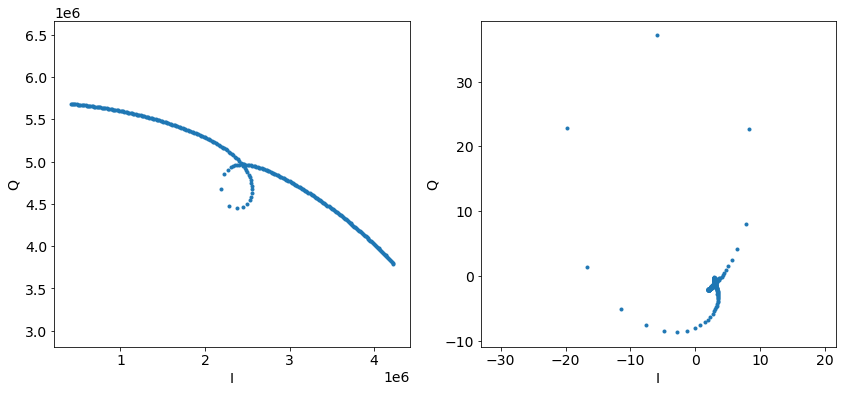

In [12]:
fig,axs = plt.subplots(1,2,figsize=(14,6))

# Plot data from Elyssa's sweep reduc for channel
x = np.real(data_srd["b'K004'"])
y = np.imag(data_srd["b'K004'"])
axs[0].plot(x,y,'.')

# Plot data from Elyssa's sweep reduc caldata
x = np.real(data_srd["b'caldata.K004'"])
y = np.imag(data_srd["b'caldata.K004'"])
axs[1].plot(x,y,'.')

for ax in axs:
    ax.set_xlabel('I')
    ax.set_ylabel('Q')
    ax.axis('equal')

plt.show()

### Plotting dI\df, dQ\df

* For the freq space, is the x dimension just the LO freqs, or is it the lo+bb freqs? Must be plus right, so lo is basically some region about where an oscillator was found. But since lo region is already like exactly centered on the f0, this seems a bit reductive.

In [13]:
# assign variables
I,Q = np.real(data_srd["b'K004'"]), np.imag(data_srd["b'K004'"])
lo = data_srd["b'lo_freqs'"]
bb = data_srd["b'bb_freqs'"] # baseband freq, each index corresponds to one channel

ff = lo+bb[4] # freq, lo + bb, currently plotting kid at channel index 4

In [14]:
# Calculate the freq derivatives of I,Q
dIdf = deriv(ff,I)
dQdf = deriv(ff,Q)

NameError: name 'deriv' is not defined

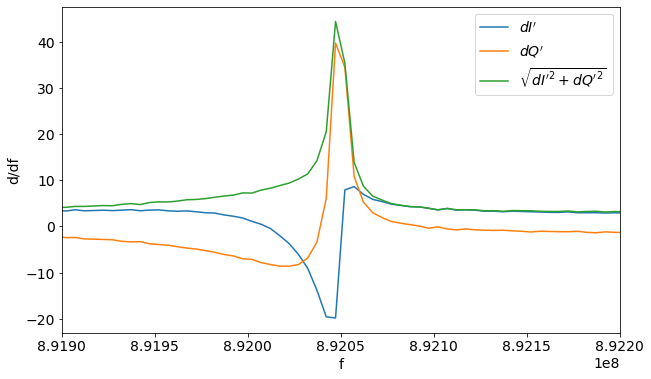

In [8]:
# Plot
fig,axs = plt.subplots(1,1,figsize=(10,6))

axs.plot(*dIdf,label='$dI^\prime$')
axs.plot(*dQdf,label='$dQ^\prime$')
axs.plot(dIdf[0],np.sqrt(dIdf[1]**2+dQdf[1]**2),label='$\sqrt{{dI^\prime}^2 + {dQ^\prime}^2}$')

axs.set_xlim(8.919e8,8.922e8)

axs.set_xlabel('f')
axs.set_ylabel('d/df')
axs.legend()

plt.show()

## Finding Resonant Freq

In truth since the Roach literally needs to find the resonant freq to then be able to sit there for a standard time stream, I think it makes a lot of sense to just use the resonant freq of the roach output since that's what the data is centered on too.

For a check of myself find the resonant freq from the above.

* It is defined as the peak of the quadrature sum of the f derivitives right?

The f0 the roach finds is considered to be exactly one of the freq bins, probably a handy enough result of the way it defines bb to be not just some rounded multiple of something.

# Calculate df/f

Now I have all the tools to apply this derivitve method to finding df/f, knowing the amplitude at the resonance can find the dI, and dQ, and I have dI' and dQ' as well.

To be honest, the roach also outputs the I0 too, and this is calculated I must assume in the same way as the f0. And indeed also finds dI/df and dQ/df, so the question is basically how much do I try to reinvent the wheel.
* Does this I0 come from before or after it rotates the IQ loop? The f0 occurs exactly at bin index 150, and is a match for the non rotated data. Nice, that's what I want to see.

I can probably do a quick setup here in which I use the given values to then plug into an eq to find df on my end, the end of that snowball is of course just using the roach output df - not exactly what I want to do. Then once I have some df, I have the abilty to go back and reteroactively define those terms using my own analysis.

In [9]:
# Get the amplitudes of f0, and I,Q at this resonance that are stored in the data

ch = 4 # again hard code the channel being tested with

f0 = data_srd["b'calparam.f0s'"][ch]
I0 = data_srd["b'calparam.i0'"][ch]
Q0 = data_srd["b'calparam.q0'"][ch]

f0_ind = np.argmin(np.abs(ff-f0)) # find the index of f0

# Get these values out and compare to what I predict from my diff. Sicne that array is N-1 len, I'm curious which index
#  they choose as the value, or maybe under the hood it does some kind of interpolation or something.
dIdf0 = data_srd["b'calparam.didf0'"][ch]
dQdf0 = data_srd["b'calparam.dqdf0'"][ch]

In [10]:
print(f0_ind)

150


In [11]:
print(f0,dIdf0)
print(dIdf[:,f0_ind-3:f0_ind+3])

892049734.0 -5.9673
[[ 8.92037234e+08  8.92042234e+08  8.92047234e+08  8.92052234e+08
   8.92057234e+08  8.92062234e+08]
 [-1.38365000e+01 -1.95955500e+01 -1.98450000e+01  7.91040000e+00
   8.62625000e+00  6.94655000e+00]]


We have got basically the right frequency at this index, but the value of the slope is about a million miles away. Try printing a range about this index? Yes, in so doing I see, this is basically one side or the other of the peak/inflection point. That seems like a massively huge danger of something going wrong! Do we need to looke for just like a min or max of the dI/df and dQ/df? Or see what I get from my magnitude of these things as the location of f0 and the assoc values?

# Toward Gao's Fit Method

This is the more robust method of the two outlined in Pete's thesis, and has a few somewhat involved steps. The first of which is to extract the cable delay phase from the data, which should be expected to circularize the IQ loop. This is also the least described step, more or less just says to do it.

### Plotting Phase(f)

This is just to explore some thinking about how cable delay factors in here, and how it might be removed.

In [5]:
# Simple linear fit func
def line(x,m,b):
    return m*x + b

In [6]:
# get phase
x = np.real(data_srd["b'K004'"])
y = np.imag(data_srd["b'K004'"])

magz = np.sqrt(x*x + y*y)
phi = np.arctan2(y,x)

As a super expedient test to see what this looks like, just fit a line over the whole thing and get a slope, and thus a phase from the cable delay's freq dependence to subtract off and give a try to see how much this circularizes the IQ loop.

* Exactly what do I do with this slope? Do I subtract it or divide it from the data. I think we need to subtract this slope times the freq from each point.

In [7]:
# Index of slice to take from ends of data
bnd = 30
ind = np.append(np.arange(30),np.arange(len(ff)-30,len(ff)))

NameError: name 'ff' is not defined

In [12]:
# Fit line
#popt, pcov = curve_fit(line,ff,phi,p0=[1e-7,1e3])

# fit just the ends of the f region
popt, pcov = curve_fit(line,ff[ind],phi[ind],p0=[1e-7,1e3])
print(popt,'+/-',np.sqrt(np.diag(pcov)))

# try just one end or the other
popt_lo, pcov_lo = curve_fit(line,ff[ind[:bnd]],phi[ind[:bnd]],p0=[1e-7,1e3])
print(popt_lo,'+/-',np.sqrt(np.diag(pcov_lo)))

popt_hi, pcov_hi = curve_fit(line,ff[ind[bnd:]],phi[ind[bnd:]],p0=[1e-7,1e3])
print(popt_hi,'+/-',np.sqrt(np.diag(pcov_hi)))

[-5.10589603e-07  4.56586430e+02] +/- [9.05528244e-11 8.07776459e-02]
[-5.21879035e-07  4.66649486e+02] +/- [2.88612954e-10 2.57261575e-01]
[-5.20629304e-07  4.65549173e+02] +/- [3.02064824e-10 2.69661498e-01]


Tyler said something about asking if the slope changes much if just using the high frequencies rather than the low freqs. In general ~ not much, order 1% for this channel, but the more important thing is probably that if the two have a different intercept (as seems to be the case) using both ends up being much more different slope than using both of them.

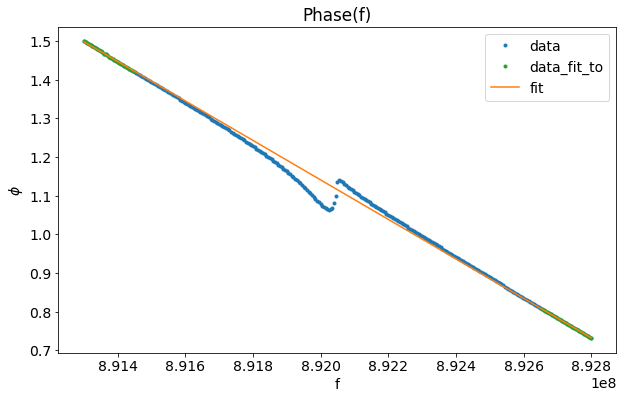

In [13]:
# Plot

fig,axs = plt.subplots(1,1,figsize=(10,6))

axs.plot(ff,phi,'.',label='data')

axs.plot(ff[ind],phi[ind],'.',label='data_fit_to',c='C2')
axs.plot(ff,line(ff,*popt),lw=1.5,label='fit',c='C1')

axs.set_title('Phase(f)')
axs.set_xlabel('f')
axs.set_ylabel('$\phi$')
axs.legend()

plt.show()

In [20]:
# Applying this attepmted correction
phi2 = phi - popt[0]*ff - popt[1]

# Get this back to an x,y I can plot and see if circular
x2 = magz*np.cos(phi2)
y2 = magz*np.sin(phi2)

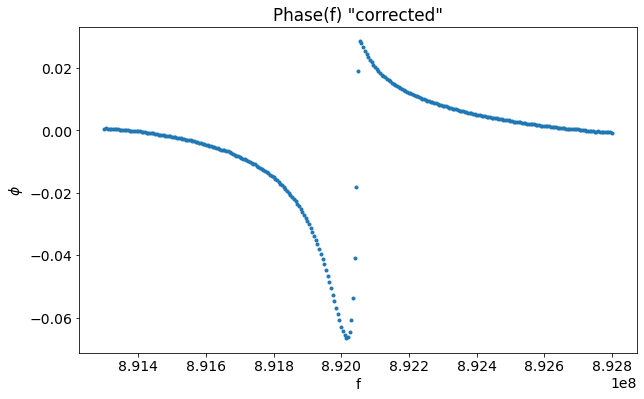

In [21]:
# Plot
fig,axs = plt.subplots(1,1,figsize=(10,6))

axs.plot(ff,phi2,'.')

axs.set_title('Phase(f) "corrected"')
axs.set_xlabel('f')
axs.set_ylabel('$\phi$')

plt.show()

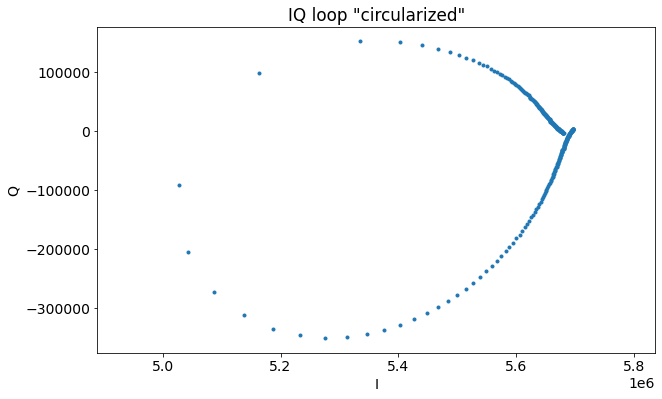

In [22]:
# Plot
fig,axs = plt.subplots(1,1,figsize=(10,6))

axs.plot(x2,y2,'.')
axs.axis('equal')

axs.set_title('IQ loop "circularized"')
axs.set_xlabel('I')
axs.set_ylabel('Q')

plt.show()

This does indeed look quite nice like I expect to see in figures in these theses - or is it? The phase is essentially flat which I do believe is what we want. The IQ loop is more of less circularized up to the fact that my super sloppy linear fit takes into account all data, not just the fringes. Let's retroactively do a better job of isolating those parts out to fit.

Having done so, this does not really look much more circular than the full line fit. It looks like it's mostly just been reflected about the y axis, it is a tiny bit more circular.

There is also of course the ever present chance that these detectors are somehow behaving oddly I better throw this in a loop and plot for all channels or something before making too strong of judgement. I suspect that "bad" channels that are mostly cable delay as Elyssa put it could illumiate the below point.

Not to mention that on this scale of the corrected phase we see that nowhere on the graph is the line flat. It is always curved, so either this data is still too close to resonance for this approx, or my correction is not quite correct since even near the very edges where I'd expect perfectly flat, it isn't.

In [8]:
# Simple linear fit func
def line(x,m,b):
    return m*x + b

In [9]:
chan_keys = fnmatch.filter(data_srd.keys(),"b'K*")

lo = data_srd["b'lo_freqs'"] # local oscillator freqs
bb = data_srd["b'bb_freqs'"] # baseband freq, each index corresponds to one channel

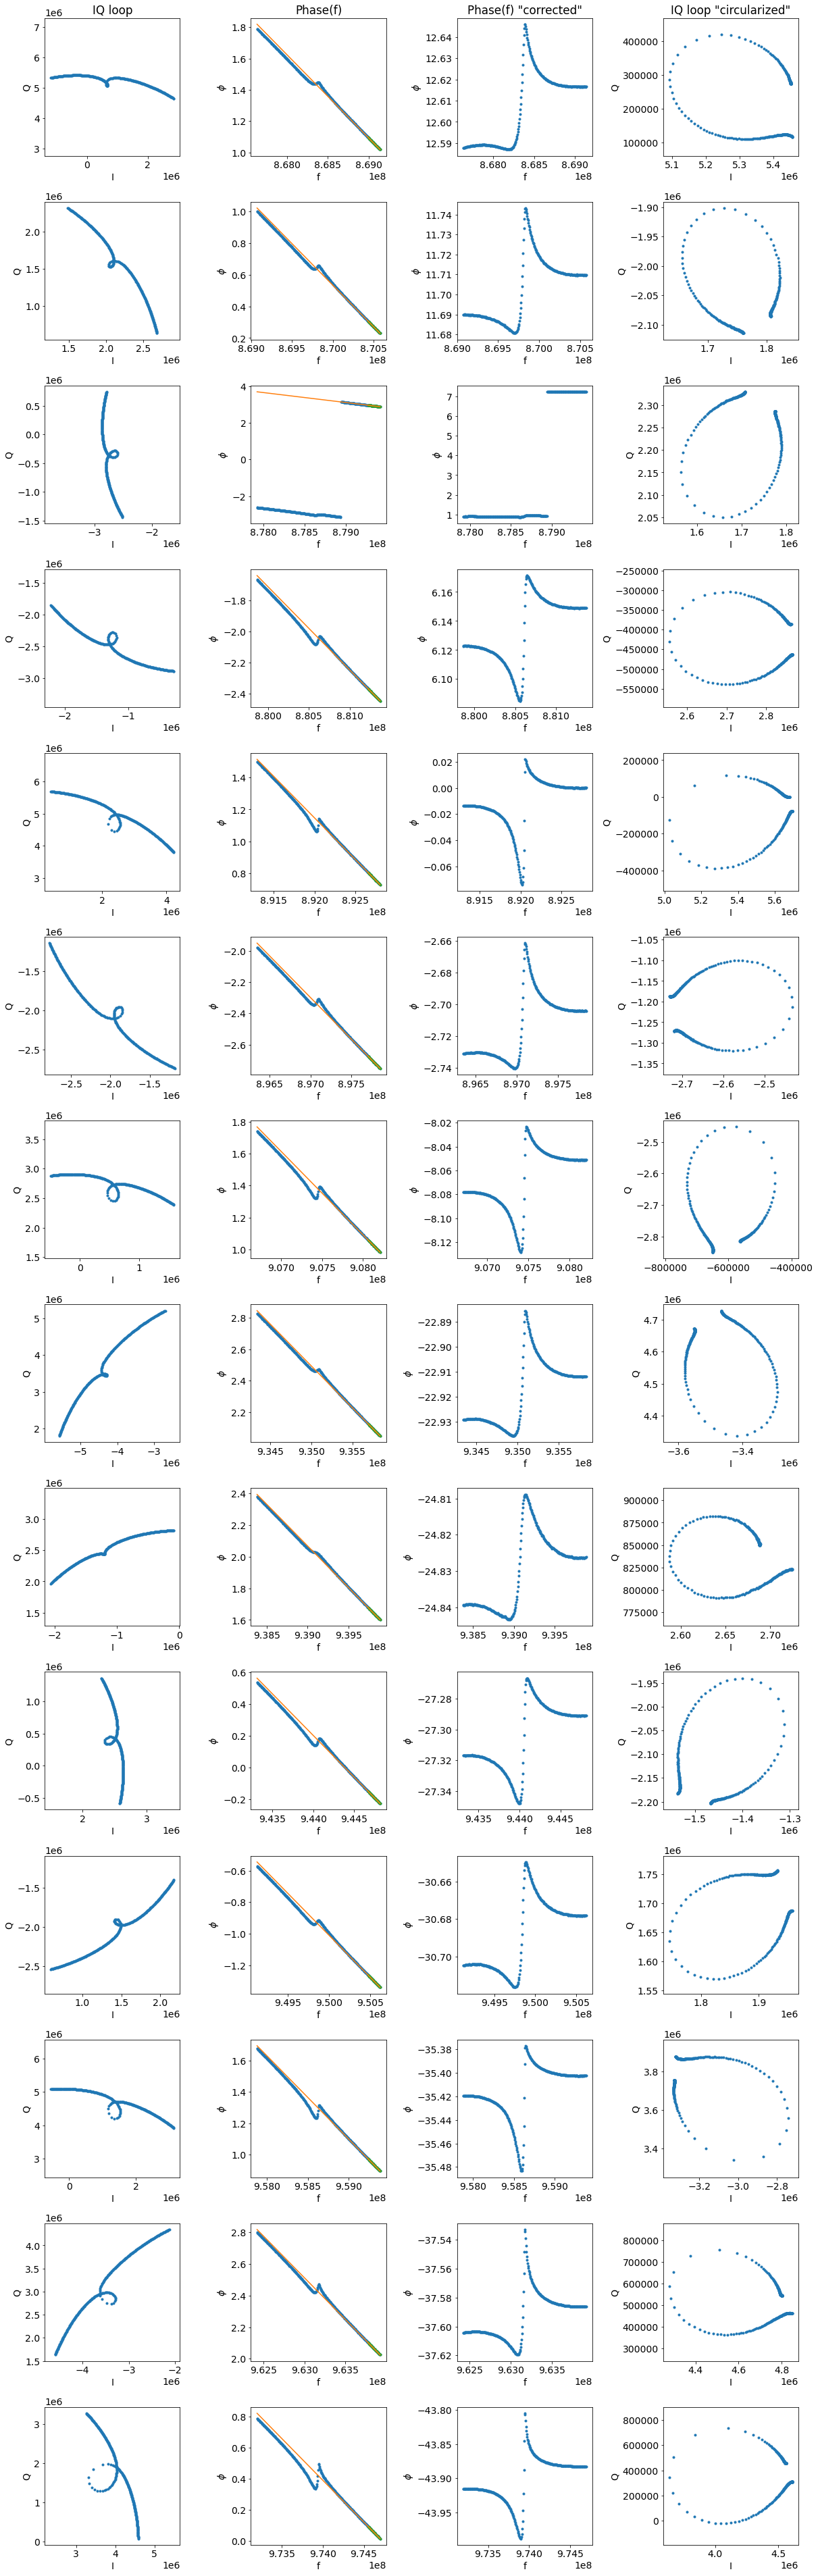

In [15]:
# Create such a loop here.

bnd = 30 # bound on ends of index edge slices
#ind = np.append(np.arange(30),np.arange(len(f)-30,len(f))) # Index of slice to take from ends of data
ind = np.arange(len(lo)-30,len(lo))

fig,axs = plt.subplots(len(chan_keys),4,figsize=(17,3.8*len(chan_keys)))

for i in range(len(axs)): # row for each channel
        
    f = lo+bb[i] # get freqs
        
    # get complex data and phase
    x = np.real(data_srd[chan_keys[i]])
    y = np.imag(data_srd[chan_keys[i]])
    magz = np.sqrt(x*x + y*y)
    phi = np.arctan2(y,x)
        
    # fit just the ends of the f region
    popt, pcov = curve_fit(line,f[ind],phi[ind],p0=[1e-7,1e3])
        
    # Applying this attepmted correction
    phi2 = phi - popt[0]*ff - popt[1]

    x2 = magz*np.cos(phi2)
    y2 = magz*np.sin(phi2)
    
    # Plot IQ
    axs[i,0].plot(x,y,'.')
    axs[i,0].axis('equal')
    
    axs[i,0].set_xlabel('I')
    axs[i,0].set_ylabel('Q')
    
    # Plot phase and fit selection
    axs[i,1].plot(f,phi,'.',label='data')
    axs[i,1].plot(f[ind],phi[ind],'.',label='data fit to',c='C2')
    axs[i,1].plot(f,line(f,*popt),lw=1.5,label='fit',c='C1')
    
    axs[i,1].set_xlabel('f')
    axs[i,1].set_ylabel('$\phi$')
    #axs[i,1].legend()
    
    # Plot phase with cable delay removed
    axs[i,2].plot(f,phi2,'.')

    axs[i,2].set_xlabel('f')
    axs[i,2].set_ylabel('$\phi$')
    
    # Plot IQ loop with cable delay removed
    axs[i,3].plot(x2,y2,'.')
    axs[i,3].axis('equal')

    axs[i,3].set_xlabel('I')
    axs[i,3].set_ylabel('Q')
    
    if i == 0: # set titles
        axs[i,0].set_title('IQ loop')
        axs[i,1].set_title('Phase(f)')
        axs[i,2].set_title('Phase(f) "corrected"')
        axs[i,3].set_title('IQ loop "circularized"')
        
plt.tight_layout()
plt.show()

#plt.savefig('cable_delay_attempt2_3_21.png')

The only one that actually looks circular in the end is one where the fit really failed since the phase wrapped, but it is evenly distributed points around the circle, which is also definitely wrong.

In most cases the "corrected" phase ends up way outside of 0 to 2pi range, so more than just using the intercept as an offset in phase needs to be accounted for.

### Crude Centering

I also thought of a really crude centering that could be done here to move toward the end goal, a match for the crude cable delay removal that I'm apparently doing. Basically estimate the center of these squashed loops just by the average of the min and max of I and Q (not taking regular averages since most points lie where the loop closes) then offset and rotate by that.

This doesn't overall look too bad. This is also after all the phase that we want to consider later when fitting the timestream data to the sweep right? Not really the "corrected" phase above, though that is a decent diagnostic tool.

The other thing still needed is to rotate this! I have only translated it so far, so that rotation must be carried out before really considering the phase. I am not super clear on how Gao does his convention. The most straightforward interpretation gets something that looks decent, but also seems to be pi offset from what I expect it should be. i.e. the dense open tails of the loop are aligned on the positive x axis while the center of the loop's diffuse part (where I think the resonance is) is aligned on -x. In Gao's thesis it is always the other way around.
* Aha, the reason was that Gao defines his translation as xcen - x, not as I had done, x - xcen. This negative sign flips it to the orientation I expected.

In [16]:
# using the variables, x,y,f etc just uses the last channel from the loop above, but that's fine
#xcen = (np.min(x2) + np.max(x2))/2 # These are all elongated in the x direction after rotation, so to refine
#  slightly compared to this, find x center as the location where the y dimension is largest (averaging simply).

# Actually note that is problematic since the loop has initially a random orientation prior to translation
#  which is defined by the xcen ycen, so assuming the shape is always elongated in x is a bad idea
#  Maybe doing a crude centering+rotation first, then a second one with that method, or fitting and ellipse
#  would be preferred? That's more complexity than is justified for now.

xcen = (x2[np.argmin(y2)] + x2[np.argmax(y2)])/2

ycen = (np.min(y2) + np.max(y2))/2

phi_cen = np.arctan2(ycen,xcen)

# Carry out the rotation as well using the phase of the center point as in Gao
# His notation makes the steps he is taking a bit unclear, logically I think he just multiplies by
#  - the center's phase to do this rotation, seperate to the translation, so the z would be the full
#  number, not just the magnitude.

# following lines under assumption that z was magz in Gao's eq E.10
#magz3 = zcen - magz
#x3 = magz3*np.cos(-phi_cen)
#y3 = magz3*np.sin(-phi_cen)

# doing the more "logical" translation then rotation as I see it
# translate
x3 = xcen - x2 # Gao defines his translation this way
y3 = ycen - y2
# convert to polar
magz3 = np.sqrt(x3**2 + y3**2)
phi3 = np.arctan2(y3,x3)
# rotate by phase of center
phi3 = phi3 - phi_cen
# convert to cartesian
x3 = magz3*np.cos(phi3)
y3 = magz3*np.sin(phi3)

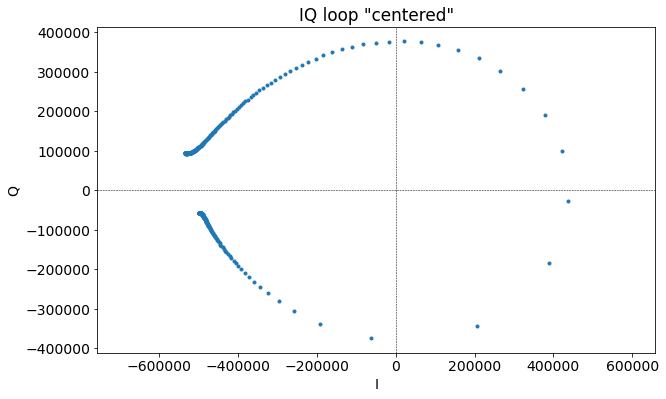

In [17]:
fig,axs = plt.subplots(1,1,figsize=(10,6))

#axs.plot(x2-xcen,y2-ycen,'.') # doing this simply looks not so bad, just no rotation

axs.plot(x3,y3,'.')
axs.axis('equal')

axs.axhline(0,ls='--',lw=.5,c='k')
axs.axvline(0,ls='--',lw=.5,c='k')


axs.set_title('IQ loop "centered"')
axs.set_xlabel('I')
axs.set_ylabel('Q')

#plt.savefig('IQ_centered_3_21.png')
plt.show()

### Phase(f) of the centered loop

This data is what will be used to interpolate df in conjunction with the timestream data, once the timestream undergoes the same cable delay correction, translation, and rotation. So all I need to do is carry on the center coords, and the sum of the 2 phases to be subtracted from the timestream.

I have not found the resonant frequency from fitting this yet however, which is the reference point we'd prefer to use for actually finding df. Again I wonder if regardless of the "actual" resonance it makes more sense to just follow the resonance that Elyssa selected when doing sweeps? Since that's where the roach actually looks? In essence if we didn't do that we would find an offset in phase so that we are already reading something above background.

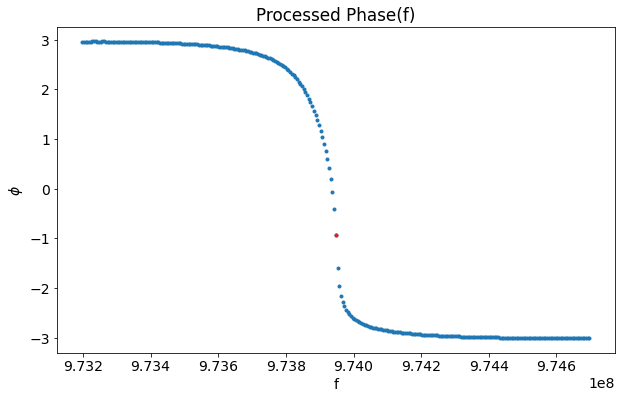

In [225]:
fig,axs = plt.subplots(1,1,figsize=(10,6))

axs.plot(f,phi3,'.')
axs.plot(f[150],phi3[150],'.',c='C3',label='roach f0') # here plotting the resonant freq as the center of the bin region
                                                       #  which is how defined on the roach.

axs.set_title('Processed Phase(f)')
axs.set_xlabel('f')
axs.set_ylabel('$\phi$')

plt.show()

### Fitting Phase(f)

For the S's and G's I can try and fit this to the arctan distribution that Gao uses, though my IQ loop is not very circular, this does basically have the shape of -2arctan(f)

The full fit should be to the model:

$\theta = -\theta_0 + 2arctan[2Q_r(1-\frac{f}{f_r})]$

In [19]:
def theta(f,fr,qr,theta_0):
    return -theta_0 + 2*np.arctan(2*qr*(1-f/fr)) # hopefully arctan2 quadrant selecting not required

In [ ]:
# fit this model
popt,pcov = curve_fit(theta,f,phi3,p0=[9.74e8,1e3,0])
phi0_model = popt[2] - np.arctan2(ycen,xcen) # as described by Gao using a geometric relationship.
print(popt)

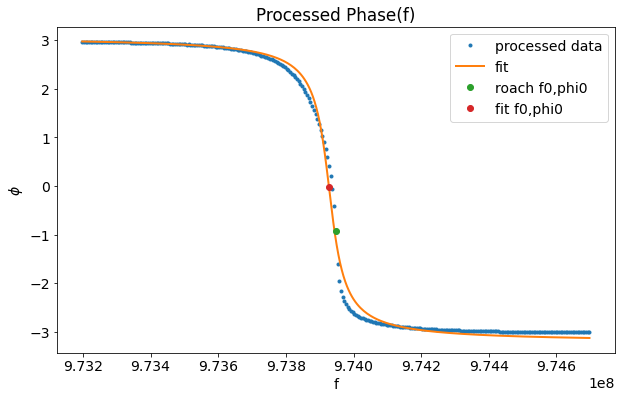

In [228]:
fig,axs = plt.subplots(1,1,figsize=(10,6))

# data/from roach
axs.plot(f,phi3,'.',label='processed data')
# model
xplot = np.linspace(np.min(f),np.max(f),300)
axs.plot(xplot,theta(xplot,*popt),lw=2,label='fit')

# mark resonant frequencies
axs.plot(f[150],phi3[150],'.',c='C2',label='roach f0,phi0',markersize=12) # here plotting the resonant freq as the center of the bin region
                                                      #  which is how defined on the roach.
axs.plot(popt[0],phi0_model,'.',c='C3',label='fit f0,phi0',markersize=12)
    
axs.set_title('Processed Phase(f)')
axs.set_xlabel('f')
axs.set_ylabel('$\phi$')
axs.legend()

#plt.savefig('phase_fit_3_21.png')
plt.show()

This looks pretty decent, certainly not perfect, but is super right track for sure. Testing with the original ind that uses both ends of the fit causes the phase to wrap with totally plays havoc with this fit. It can be pretty easily fixed, but in truth I have doubts about that ind given the difference in performance, and that the loop overlaps itself in that case. This is cleaner and more like what the ideal is expected to be, ie not a fully closed loop.

## Expand on the previous figure for all channels

Add the rotated and translated loop and the final phase(f) and fit for all channels

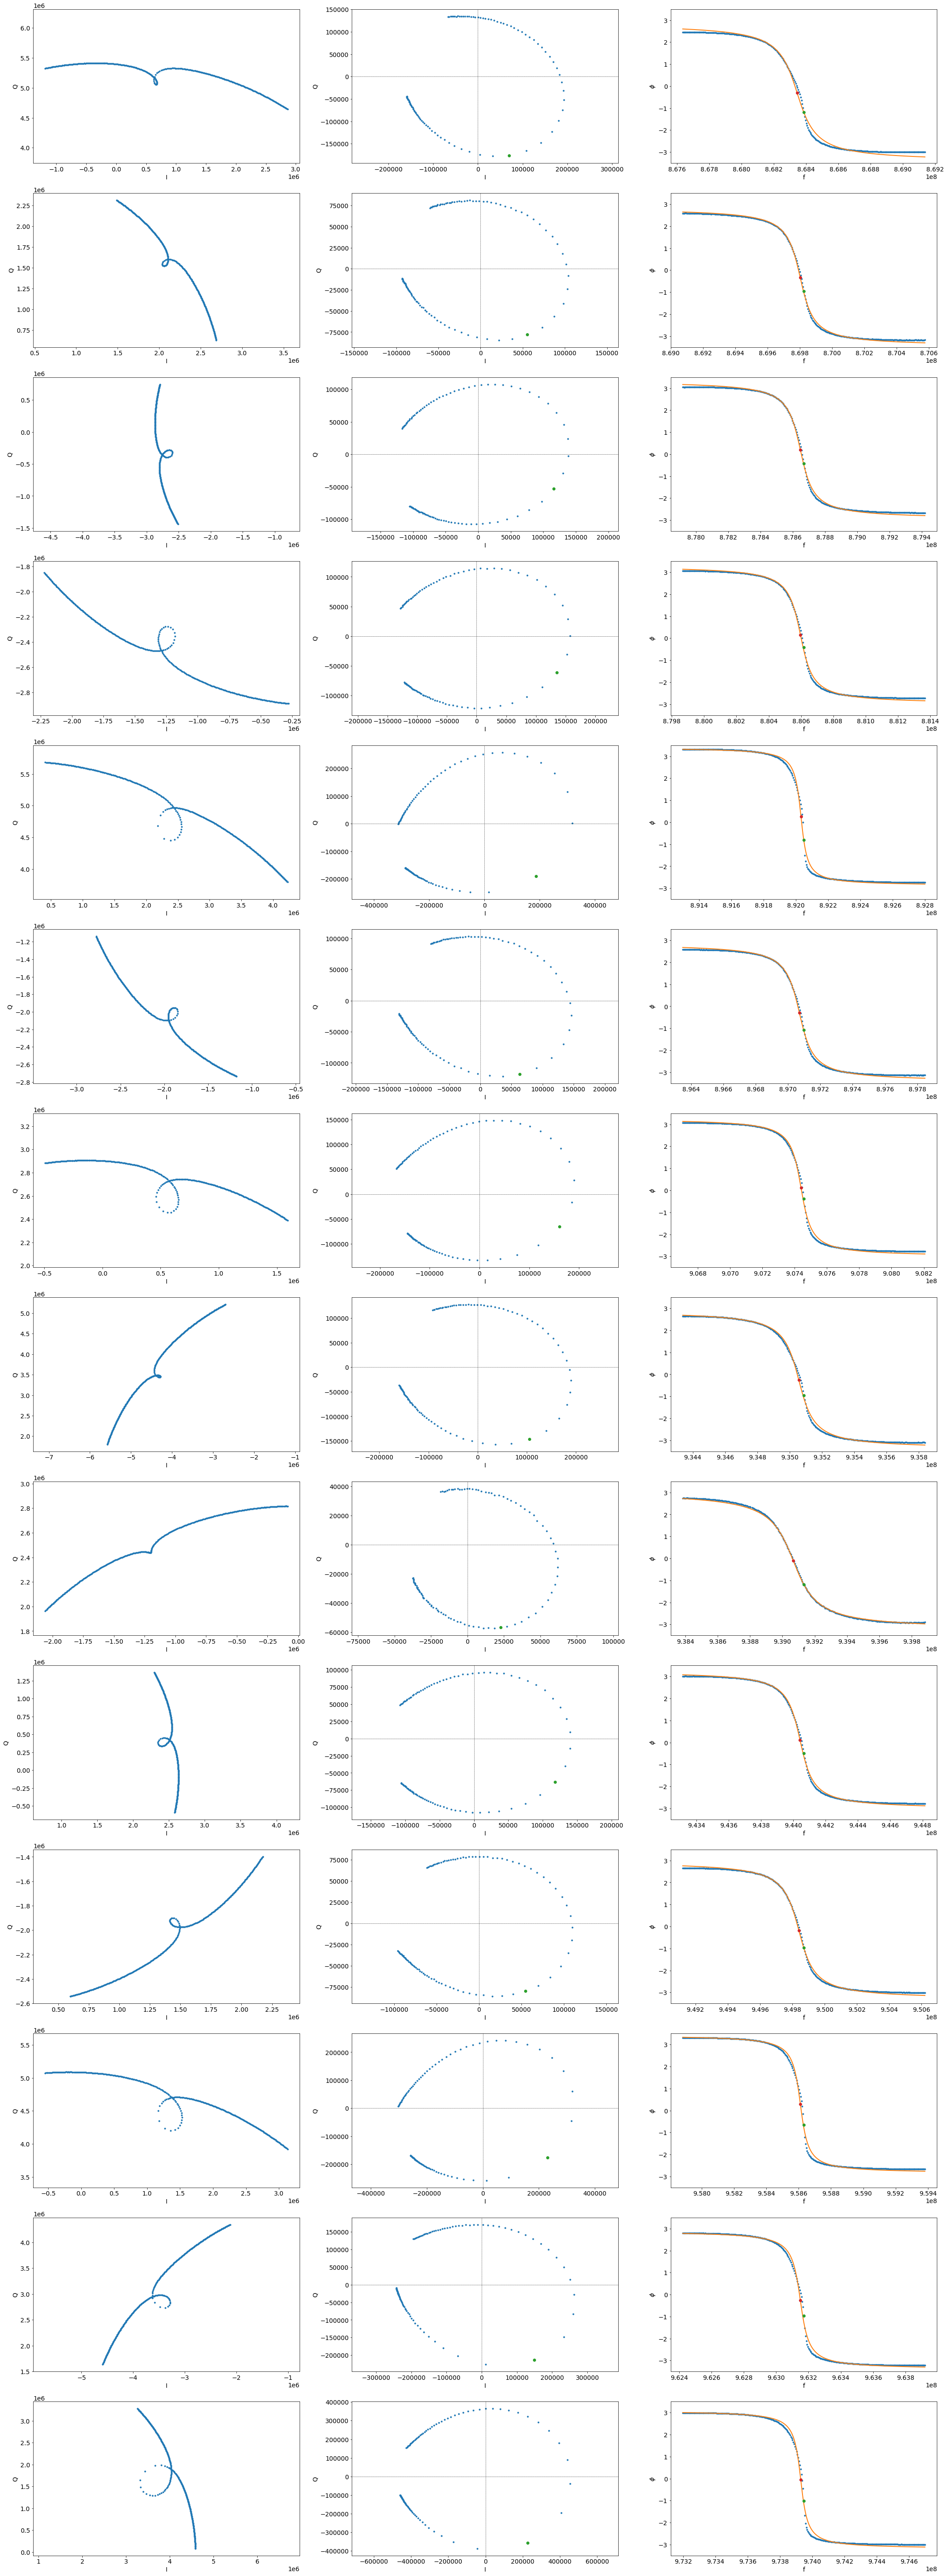

In [22]:
# Create such a loop here.

bnd = 30 # bound on ends of index edge slices
#ind = np.append(np.arange(30),np.arange(len(f)-30,len(f))) # Index of slice to take from ends of data
ind = np.arange(len(lo)-30,len(lo))

bnd2 = 100

wrap_crit = 3/2*np.pi # the criteria for how close to pi,-pi to consider that it has been wrapped

fig,axs = plt.subplots(len(chan_keys),3,figsize=(30,5.8*len(chan_keys)))

for i in range(len(axs)): # row for each channel
        
    f = lo+bb[i] # get freqs
        
    # get complex data and phase
    x = np.real(data_srd[chan_keys[i]])
    y = np.imag(data_srd[chan_keys[i]])
    magz = np.sqrt(x*x + y*y)
    phi = np.arctan2(y,x)
        
    # fit just the ends of the f region
    popt, pcov = curve_fit(line,f[ind],phi[ind],p0=[1e-7,1e3])
        
    # Applying this attepmted correction
    phi2 = phi - popt[0]*f #- popt[1]

    x2 = magz*np.cos(phi2)
    y2 = magz*np.sin(phi2)
    
    # Find the center of the corrected loop and translate+rotate to origin
    #xcen = (x2[np.argmin(y2)] + x2[np.argmax(y2)])/2 # x center on max region of y width
    xcen = (np.min(x2) + np.max(x2))/2 # simple x centering
    ycen = (np.min(y2) + np.max(y2))/2
    
    phi_cen = np.arctan2(ycen,xcen)

    x3 = xcen - x2 # Gao defines his translation this way
    y3 = ycen - y2
    # convert to polar
    magz3 = np.sqrt(x3**2 + y3**2)
    phi3 = np.arctan2(y3,x3)
    # rotate by phase of center
    phi3 = phi3 - phi_cen
    
    # for the fitting in next step, un wrap phi about -pi to pi since wrapping breaks the fit
    discont,k = False,0
    while not discont and k < len(phi3)-2: # len -1 for 0 index and -1 more for k+1 used in loop
        # check for discontinuity
        if np.abs(phi3[k+1] - phi3[k]) > wrap_crit:
            discont = True
        k += 1 # I am relying on adding 1 even after discont found in next step
    if discont:
        #print(i,discont,means)
        means = np.array([np.mean(phi3[:k]),np.mean(phi3[k:])])
        if np.abs(means[0]) > np.abs(means[1]): # the left side needs to be wrapped
            if means[0] < 0: # left side on bottom, needs to be wrapped to top
                phi3[:k] = phi3[:k] + 2*np.pi
            else: # on top, needs to be wrapped to bottom
                phi3[:k] = phi3[:k] - 2*np.pi
        else: # assume only other case is opposite
            if means[1] < 0: # right side on bottom, needs to be wrapped to top
                phi3[k:] = phi3[k:] + 2*np.pi
            else: # on top, needs to be wrapped to bottom
                phi3[k:] = phi3[k:] - 2*np.pi
        
    # convert to cartesian
    x3 = magz3*np.cos(phi3)
    y3 = magz3*np.sin(phi3)
    
    # Fit Gao's phase distribution
    popt3,pcov3 = curve_fit(theta,f,phi3,p0=[f[150],1e3,0.0])
    #phi0_model = popt3[2] - np.arctan2(ycen,xcen) # find phi_0 as described by Gao using a geometric relationship.
    # Has issues stated below, and not sure why this is done. Instead just find the resonant phase from the model
    phi0_model = theta(popt3[0],*popt3)
    
    # Plot IQ
    c = 0 # which col currently on
    axs[i,c].plot(x,y,'.')
    axs[i,c].axis('equal')
    
    axs[i,c].set_xlabel('I')
    axs[i,c].set_ylabel('Q')
    
    # Plot phase and fit selection
#    c += 1
#    axs[i,c].plot(f,phi,'.',label='data')
#    axs[i,c].plot(f[ind],phi[ind],'.',label='data fit to',c='C2')
#    axs[i,c].plot(f,line(f,*popt),lw=1.5,label='fit',c='C1')
    
#    axs[i,c].set_xlabel('f')
#    axs[i,c].set_ylabel('$\phi$')
#    #axs[i,c].legend()
    
    # Plot phase with cable delay removed
#    c += 1
#    axs[i,c].plot(f,phi2,'.')

#    axs[i,c].set_xlabel('f')
#    axs[i,c].set_ylabel('$\phi$')
    
    # Plot IQ loop with cable delay removed
#    c += 1
#    axs[i,c].plot(x2,y2,'.')
#    axs[i,c].axis('equal')

#    axs[i,c].set_xlabel('I')
#    axs[i,c].set_ylabel('Q')
    
    # Plot the translated, rotated loop
    c += 1 
    axs[i,c].plot(x3[bnd2:-bnd2],y3[bnd2:-bnd2],'.')
    axs[i,c].axis('equal')
    # mark out center lines
    axs[i,c].axhline(0,ls='--',lw=.5,c='k')
    axs[i,c].axvline(0,ls='--',lw=.5,c='k')

    axs[i,c].set_xlabel('I')
    axs[i,c].set_ylabel('Q')
    
    # mark resonant frequencies
    axs[i,c].plot(x3[150],y3[150],'.',c='C2',label='roach f0,phi0',markersize=12) # here plotting the resonant freq as the center of the bin region
                                                      #  which is how defined on the roach.
    #axs[i,c].plot(popt3[0],phi0_model,'.',c='C3',label='fit f0,phi0',markersize=12) #not sure if this can be plotted in IQ
    
    # Plot the final processed phase(f) and fits
    c += 1
    axs[i,c].plot(f,phi3,'.',label='processed data')
    # model
    xplot = np.linspace(np.min(f),np.max(f),300)
    axs[i,c].plot(xplot,theta(xplot,*popt3),lw=2,label='fit')
    # mark resonant frequencies
    axs[i,c].plot(f[150],phi3[150],'.',c='C2',label='roach f0,phi0',markersize=12) # here plotting the resonant freq as the center of the bin region
                                                      #  which is how defined on the roach.
    axs[i,c].plot(popt3[0],phi0_model,'.',c='C3',label='fit f0,phi0',markersize=12)
        
    axs[i,c].set_ylim(-3.5,3.5)
    axs[i,c].set_xlabel('f')
    axs[i,c].set_ylabel('$\phi$')
    #axs.legend()
    
#    if i == 0: # set titles
#        axs[i,0].set_title('IQ loop')
#        axs[i,1].set_title('Phase(f)')
#        axs[i,2].set_title('Phase(f) "corrected"')
#        axs[i,3].set_title('IQ loop "circularized"')
#        axs[i,4].set_title('IQ loop "centered"')
#        axs[i,5].set_title('Processed Phase(f)')
        
plt.tight_layout()
plt.show()

#plt.savefig('cable_delay_attempt2_3_21.png')

Looking at this method on all channels, it is very clear there is an issue with the phase wrapping creating a discontinuity in the phase distribution and breaking the fit. The cases where the opening of the loop is aligned with the x axis work perfectly fine, so the question is whether it should always do so and part of my process is not careful enough, or if I need to just force it to not wrap and count on the $\theta_0$ offset, which should be just fine as long as the loops don't close over themselves.

Getting it unwrapped was definitely a bit of a challenge to make agreeable, and relying on the value of $\theta_0$ as an offset works to get the fit to match, however the strict use of that quantity to produce the y coord of the resonant freq definitely causes some issues. Surprisingly mostly in the 0th index, where there is no wrapping/unwrapping at all. It places that dot at a y val quite a large amount off the line of the fit for some reason. Rather than Gao's argument, I may need to just use the y that comes out from putting in f_r as the x. Beyond the question of just making the graph look nice, this is something I will need to read up on further before deciding what to do about it. There's also a few cases where the wrap isn't just a boundary crossed once, but might come back over it, so basically I can't find a single discontinuity only and move one side or the other of it in all cases. That leads to a few stragglers unfortunately, but could be found to lead to more issues further on. These are of course only in the super dense tails, far from the data we care about, so it's probably just as well to remove them or even just change the graph bounds to hide them since they don't even really change the fit.

On further reading, I have absolutely no idea why Gao defines $\phi_0$ from $\theta_0$ in this way. So for now I will change to consider the resonant phase to base the phase the model produces fro the resonant frequency. In so doing the dots now all lie on the line.

As expected they differ from the green dot in the same direction in all places, since Elyssa deliberately selected a freq to watch the is to one side of the true resonance.

In [ ]:
# The next step is to put some ofthese code blocks into functions so it's not so redundant and ridiculous,
#  and do some exploration of applying to timestream data to find df and look at that.

# Meet Tyler Apr 6:

Karia's df script is probably month+ out, so just get my df fitting to the final step and use that for my project report.

Need to get my stuff running on the LL127 computer - shouldn't be too hard

Need to codify my setup in some way - ideally on wiki I'm not on now.
Might just be that I should make a pdf or google doc or etc right now with pics, labels, procedures that can be posted/shared.

Note to self - still need to make a good cover for the filter!


For 335, Tyler thinks really we only need to analyze like one data set, ie when we changed temp a few times.
In there is also data about angles/etc

So we could also our narrative that we got everythign working for a first time, then chased after systematics - such as tilting the grid. Hardening the setup, etc. That narrative would keep more in the hardware realm. Talk about the development and how it is already become a standard testing procedure.

Figure out from the data exactly what tilting it did.

# Apr 11 Onward

Need to get serious on codifying this stuff into some functions and moving it to another notebook. Make and do some quick testing of the funcs here

In [ ]:
def find_sweep(infile): # Given a data file find the sweep file that corresponds, probably put in a prompt where it
    # asks the user for the path if it cannot find it or is unsure.
    return swfile
    
def read_sweep(infile): # simply read the sweep data
    
    # call find_sweep? Then read the file it produces - or seperate to just do with the output of find_sweep
    
    # read the file
    
    # find kid channel freqs
    # find kid channel IQ data
    
    return kidno,sw_freq,sw_IQ

def cable_fit(sw_freq,sw_IQ): # this fits the cable delay to produce the parameter needed to circularize

    # convert to phase(f)
    
    # fit linear model to first and last ~30 points
    # average the 2 models to find slope
    
    # do I want also the y intercept, or to try and remove offsets down to 0 < phi < 2pi?
    
    return slope
    
def circularize(sw_IQ,slope):
    
    # normalize phase by that slope from cable delay
    
    return(IQ_circ)
    
def get_center(IQ_circ): # this finds the center coords to be used for translation and rotation, needs circularized first
    
    # this is just super simple currently, as above taking the average of the extents - can be changed later
    
    return x_cen # array vector
    
def trans_rot(IQ_circ,xcen):
    # translate the circularized data by xcen, and rotate by phase defined by xcen
    
    return IQ_out
    
def transform(IQ_in,slope,xcen):
    # This will apply the cicularization and translation+rotation
    # Want this to apply generally, so given params do the transformation. For the sweep data this might be a bit redundant
    #  since to get each of these params we do this step by step - so this might be more for just applying to final data.
    
    return IQ_out
    
def unwrap(IQ_in): # maybe this can go in phase fit?
    # I actually think to be safe the data being read in from timestreams should be unwrapped since they are to be
    #  interpolated onto the sweep fit. In principle if we are always near the inflection pt, it won't matter, but to be safe
    # so in that case it should also go inside transform. . .
    
    return IQ_uw
    
def gao_fit(sw_freq,IQ_uw): # this is really only to find phi_0, so depending on if we use the angle from this fit, may not need it
    # for generality either way will just save phi_0 so can be edited without changing downstream.
    
    # call scipy method to fit the model from GAO
    
    return phi0
    
def interp(sw_freq,IQ_uw): # maybe this can go inside phase fit
    # Thinking of making this be just some cubic func - may need to be more complicated spline, but simpler the better
    #  for storing in a lookup table I think, unless scipy interpolate has a nice save/read function
    
    # more general scipy spline or poly fit
    
    return # either the funtion's params or func itself?
    
def save_params():
    # Need to save the 3 sets of params in one place, probably one file per sweep than can be pointed to later
    #  or ideally have some method that will find the correct file given an input data file
    
    # each channel in sweep has a seperate set of params, so I think it makes sense to call this once per chan
    #  and have it append a line with chan number, slope, xcen, phi0 tentatively
    
# That is the end of the methods I think I need to the sweep side, below are forseen funcs on the data side

def read_timestream(infile):
    
    # read in the whole data set I think, and pick out the IQ and freqs, as above for the sweep
    # Hmm, I'll want to have some way to index by kid channel - or keep that stored alonge somewhere
    #  for reference later and for lableling, etc
    
    return kidno,freq?,IQ_ts
    
def read_params(infile): # read the correct params, which can then be passed into transform, and generate there a function
    # f(phi) to feed to below
    # I think this will be called overall, for all chan in the data file, allowing sub funcs to do the looping, etc
    
    # ideally this infile is just the data file, and it searches for the param file that corresponds.
    # maybe also in that case, if not found it.
    
    return # the params, inc whatever is needed to build the function f(phi)
    
def get_dfof(IQ,func,phi0): # Plug in the params that are read and the data to find freq, subtract phi_0, and normalize by freq
    # called after transforming the data
    
    return dfof
    
# so I think that's it.